In [7]:
import pandas as pd
from ast import literal_eval
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from statistics import mean, median
import scipy
from sklearn.decomposition import PCA
from sklearn import preprocessing
from gprofiler import GProfiler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import operator
import qvalue as qv


new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)


In [13]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

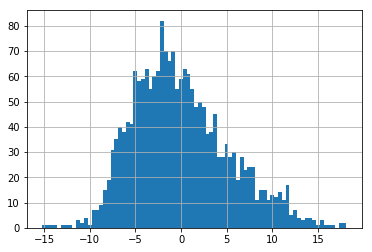

In [14]:
pca_per_pathway['Mitotic G1 phase and G1/S transition'].hist(bins=80)

In [15]:
for i in new_clinical.columns:
    print(i)

Lymph nodes examined positive
Nottingham prognostic index
Cellularity
Chemotherapy
Cohort
ER status measured by IHC
HER2 status measured by SNP6
Hormone Therapy
Inferred Menopausal State
Integrative Cluster
Age at Diagnosis
Overall Survival (Months)
Overall Survival Status
Pam50 + Claudin-low subtype
3-Gene classifier subtype
Patient's Vital Status
Primary Tumor Laterality
Radio Therapy
Tumor Other Histologic Subtype
Type of Breast Surgery
Sample Identifier
Cancer Type
Cancer Type Detailed
ER Status
HER2 Status
Neoplasm Histologic Grade
Oncotree Code
PR Status
Sample Type
Tumor Size
Tumor Stage
Triple Neg
ER-/PR-/HER2+


In [16]:
def cluster_clin(clinical_cat, clustergroups):
    full_df[f'high {clustergroups}'] = full_df.apply(lambda row: True if (row[clustergroups] > (full_df[clustergroups].mean() + 2*full_df[clustergroups].std())) else False, axis = 1)
    ER_pos_neg = full_df.groupby(f'high {clustergroups}')
    print('total')
    full_grp = full_df[clinical_cat].value_counts()
    full_series_len = full_df[clinical_cat].count()
    full_grp_df = pd.DataFrame()
    full_grp_df['counts'] = full_grp
    full_grp_df['%'] = round(100*(full_grp/full_series_len),2)
    print(full_grp_df)
    print('\n\n\n')
    for group in ER_pos_neg:
        grp = group[1]
        grp2 = grp[clinical_cat].value_counts()
        series_len = grp[clinical_cat].count()
        df = pd.DataFrame()
        df['counts'] = grp2
        df['%'] = round(100*(grp2/series_len),2)
        print(f'cluster {group[0]}')
        print(df)
        print()
cluster_clin("Patient's Vital Status", 'Gene expression (Transcription)')

total
                      counts      %
Living                   837  42.27
Died of Disease          646  32.63
Died of Other Causes     497  25.10




cluster False
                      counts      %
Living                   817  43.16
Died of Disease          616  32.54
Died of Other Causes     460  24.30

cluster True
                      counts      %
Died of Other Causes      37  42.53
Died of Disease           30  34.48
Living                    20  22.99



In [17]:
def generate_ORA_df():
    df_ORA = pd.DataFrame()
    clinical_columns = [ 'ER Status', 'PR Status', 'HER2 Status', 'Triple Neg', "Patient's Vital Status", 'Cellularity']
    for col in new_clinical.columns:
            if col in clinical_columns:
                val_counts = new_clinical[col].value_counts()
                for i in val_counts.index.values:
                    df_ORA[col + ' == ' + str(i)] = 0
    df_ORA['number of patients'] = 0
    return df_ORA

In [18]:
def ORA(): 
    df_ORA = generate_ORA_df()
    for column in pca_per_pathway.columns:
        df = pca_per_pathway[column]
        activity = df.apply(lambda row: 'High' if (row > (df.mean() + 2*df.std())) else 'Low')
        high_activity = activity.loc[activity == 'High'].index.tolist()
        high_activity_df = pd.DataFrame(index = high_activity)
        high_activity_df = pd.concat([high_activity_df, new_clinical.reindex(high_activity_df.index)], axis = 1)
        clinical_columns = ['number of patients', 'ER Status', 'PR Status', 'HER2 Status', 'Triple Neg', "Patient's Vital Status", 'Cellularity']
        grouped_dict = {}
        grouped_dict['number of patients'] = len(high_activity)
        for col in high_activity_df.columns:
            if col in clinical_columns:
                val_counts = high_activity_df[col].value_counts()  
                val_percentage = (100*(val_counts/(high_activity_df.shape[0]))).to_dict()
                for i in val_percentage:
                    val_percentage[col + ' == '+ str(i)] = val_percentage.pop(i)
                    grouped_dict.update(val_percentage)
        df_ORA.loc[column] = pd.Series(grouped_dict)
        progress = round(100*(pca_per_pathway.columns.get_loc(column)/pca_per_pathway.shape[1]),1)
        if progress in [10.0, 20.0, 30.0, 40.0, 50.0, 60.0 ,70.0, 80.0, 90.0, 95.0]:
            print(progress)
    return df_ORA
        
    
ORA_df = ORA()
ORA_df

10.0
10.0
20.0
20.0
30.0
30.0
40.0
40.0
50.0
50.0
50.0
60.0
60.0
70.0
70.0
80.0
80.0
90.0
90.0
95.0
95.0


,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
Interleukin-6 signaling,34.146341,34.146341,20.731707,69.512195,19.512195,10.975610,50.000000,50.000000,96.341463,3.658537,28.048780,71.951220,57.317073,42.682927,82.0
Apoptosis,56.451613,38.709677,4.838710,25.806452,33.870968,40.322581,87.096774,12.903226,83.870968,16.129032,64.516129,35.483871,96.774194,3.225806,62.0
Hemostasis,63.829787,34.042553,2.127660,12.765957,40.425532,46.808511,95.744681,4.255319,91.489362,8.510638,70.212766,29.787234,100.000000,NaN,47.0
Intrinsic Pathway for Apoptosis,56.000000,40.000000,4.000000,26.000000,36.000000,38.000000,88.000000,12.000000,86.000000,14.000000,62.000000,38.000000,98.000000,2.000000,50.0
PKB-mediated events,34.426230,37.704918,19.672131,54.098361,24.590164,21.311475,45.901639,54.098361,90.163934,9.836066,18.032787,81.967213,55.737705,44.262295,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,48.148148,35.802469,9.876543,54.320988,30.864198,14.814815,33.333333,66.666667,83.950617,16.049383,13.580247,86.419753,49.382716,50.617284,81.0
Signaling by the B Cell Receptor (BCR),52.873563,32.183908,9.195402,55.172414,27.586207,16.091954,26.436782,72.413793,86.206897,12.643678,11.494253,87.356322,39.080460,59.770115,87.0
Ion channel transport,68.571429,25.714286,2.857143,8.571429,42.857143,48.571429,97.142857,2.857143,94.285714,5.714286,71.428571,28.571429,97.142857,2.857143,35.0
Activation of GABAB receptors,45.312500,42.187500,9.375000,26.562500,34.375000,39.062500,89.062500,10.937500,96.875000,3.125000,67.187500,32.812500,90.625000,9.375000,64.0


In [19]:
for column in ORA_df:
    if column != 'Triple Neg == False':
        stuff = ORA_df.loc[ORA_df[column] >= 97]
        if stuff.empty:
            pass
        else:
            print(column)
            print(stuff.index.tolist())
            print("")

ER Status == Positive
['Neurotransmitter release cycle', 'Neurotransmitter clearance', 'ABC transporters in lipid homeostasis', 'Glycerophospholipid biosynthesis', 'Phospholipid metabolism', 'DAG and IP3 signaling', 'Sphingolipid de novo biosynthesis', 'Neurotoxicity of clostridium toxins', 'Activation of C3 and C5', 'Serotonin Neurotransmitter Release Cycle', 'Norepinephrine Neurotransmitter Release Cycle', 'Microtubule-dependent trafficking of connexons from Golgi to the plasma membrane', 'Gap junction assembly', 'Transport of connexons to the plasma membrane', 'Mineralocorticoid biosynthesis', 'Glucocorticoid biosynthesis', 'Metabolism of steroid hormones', 'Metabolism of vitamins and cofactors', 'Glutamate Neurotransmitter Release Cycle', 'Cytochrome P450 - arranged by substrate type', 'Phase I - Functionalization of compounds', 'Endogenous sterols', 'Dopamine Neurotransmitter Release Cycle', 'Synthesis of epoxy (EET) and dihydroxyeicosatrienoic acids (DHET)', 'Visual phototransduc

In [20]:
ORA_df.loc[ORA_df["Patient's Vital Status == Died of Disease"] > 50].sort_values(by="Patient's Vital Status == Died of Disease", ascending = False)

,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
Striated Muscle Contraction,41.666667,33.333333,16.666667,16.666667,58.333333,25.000000,58.333333,41.666667,91.666667,8.333333,41.666667,58.333333,66.666667,33.333333,12.0
LGI-ADAM interactions,52.631579,36.842105,5.263158,26.315789,57.894737,15.789474,73.684211,26.315789,94.736842,5.263158,52.631579,47.368421,78.947368,21.052632,19.0
Sperm Motility And Taxes,58.064516,30.107527,9.677419,20.430108,53.763441,25.806452,58.064516,41.935484,43.010753,56.989247,32.258065,67.741935,90.322581,9.677419,93.0
Synthesis of 5-eicosatetraenoic acids,51.724138,37.931034,10.344828,20.689655,53.448276,25.862069,74.137931,25.862069,86.206897,13.793103,37.931034,62.068966,79.310345,20.689655,58.0
GDP-fucose biosynthesis,63.636364,30.303030,4.545455,30.303030,53.030303,16.666667,36.363636,63.636364,72.727273,27.272727,18.181818,81.818182,59.090909,40.909091,66.0
Transport of fatty acids,58.823529,29.411765,5.882353,32.352941,52.941176,11.764706,58.823529,38.235294,91.176471,5.882353,35.294118,61.764706,67.647059,29.411765,34.0
FGFRL1 modulation of FGFR1 signaling,49.206349,46.031746,4.761905,22.222222,52.380952,25.396825,61.904762,38.095238,88.888889,11.111111,41.269841,58.730159,71.428571,28.571429,63.0
SLBP independent Processing of Histone Pre-mRNAs,64.788732,32.394366,2.816901,38.028169,52.112676,9.859155,29.577465,70.422535,90.140845,9.859155,18.309859,81.690141,38.028169,61.971831,71.0
Fertilization,56.321839,29.885057,9.195402,22.988506,51.724138,25.287356,27.586207,72.413793,43.678161,56.321839,8.045977,91.954023,77.011494,22.988506,87.0
GRB2:SOS provides linkage to MAPK signaling for Integrins,41.428571,41.428571,12.857143,34.285714,51.428571,14.285714,44.285714,55.714286,52.857143,47.142857,34.285714,65.714286,82.857143,17.142857,70.0


In [21]:
def ORA(): 
    df_ORA = generate_ORA_df()
    for column in pca_per_pathway.columns:
        df = pca_per_pathway[column]
        activity = df.apply(lambda row: 'High' if (row < (df.mean() - 2*df.std())) else 'Low')
        high_activity = activity.loc[activity == 'High'].index.tolist()
        high_activity_df = pd.DataFrame(index = high_activity)
        high_activity_df = pd.concat([high_activity_df, new_clinical.reindex(high_activity_df.index)], axis = 1)
        clinical_columns = ['number of patients', 'ER Status', 'PR Status', 'HER2 Status', 'Triple Neg', "Patient's Vital Status", 'Cellularity']
        grouped_dict = {}
        grouped_dict['number of patients'] = len(high_activity)
        for col in high_activity_df.columns:
            if col in clinical_columns:
                val_counts = high_activity_df[col].value_counts()  
                val_percentage = (100*(val_counts/(high_activity_df.shape[0]))).to_dict()
                for i in val_percentage:
                    val_percentage[col + ' == '+ str(i)] = val_percentage.pop(i)
                    grouped_dict.update(val_percentage)
        df_ORA.loc[column] = pd.Series(grouped_dict)
        progress = round(100*(pca_per_pathway.columns.get_loc(column)/pca_per_pathway.shape[1]),1)
        if progress in [10.0, 20.0, 30.0, 40.0, 50.0, 60.0 ,70.0, 80.0, 90.0, 95.0]:
            print(progress)
    return df_ORA
        
negative_ORA_df = ORA()
negative_ORA_df


10.0
10.0
20.0
20.0
30.0
30.0
40.0
40.0
50.0
50.0
50.0
60.0
60.0
70.0
70.0
80.0
80.0
90.0
90.0
95.0
95.0


,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
Interleukin-6 signaling,51.612903,38.709677,9.677419,12.903226,48.387097,38.709677,83.870968,16.129032,74.193548,25.806452,48.387097,51.612903,93.548387,6.451613,31.0
Apoptosis,69.767442,16.279070,9.302326,65.116279,20.930233,9.302326,30.232558,67.441860,88.372093,6.976744,13.953488,81.395349,37.209302,60.465116,43.0
Hemostasis,24.074074,42.592593,20.370370,68.518519,24.074074,7.407407,20.370370,79.629630,96.296296,3.703704,7.407407,92.592593,25.925926,74.074074,54.0
Intrinsic Pathway for Apoptosis,62.962963,25.925926,7.407407,53.703704,37.037037,7.407407,20.370370,79.629630,92.592593,5.555556,11.111111,87.037037,25.925926,74.074074,54.0
PKB-mediated events,75.757576,15.151515,NaN,51.515152,24.242424,24.242424,87.878788,12.121212,93.939394,3.030303,45.454545,51.515152,90.909091,9.090909,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Signaling by the B Cell Receptor (BCR),57.142857,38.095238,NaN,19.047619,42.857143,38.095238,85.714286,14.285714,80.952381,19.047619,61.904762,38.095238,95.238095,4.761905,21.0
Ion channel transport,51.923077,30.769231,17.307692,51.923077,40.384615,7.692308,3.846154,96.153846,96.153846,3.846154,1.923077,98.076923,7.692308,92.307692,52.0
Activation of GABAB receptors,42.857143,40.000000,8.571429,62.857143,25.714286,5.714286,57.142857,40.000000,88.571429,5.714286,40.000000,54.285714,60.000000,37.142857,35.0


In [22]:
negative_ORA_df.loc[negative_ORA_df["Patient's Vital Status == Died of Disease"] > 80].sort_values(by="Patient's Vital Status == Died of Disease", ascending = False)

,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
Biogenic amines are oxidatively deaminated to aldehydes by MAOA and MAOB,100.000000,NaN,NaN,NaN,100.000000,NaN,50.000000,50.000000,100.000000,NaN,NaN,100.000000,50.000000,50.000000,2.0
Digestion of dietary lipid,100.000000,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,1.0
Signaling by BMP,NaN,50.000000,50.0,NaN,100.000000,NaN,50.000000,50.000000,100.000000,NaN,50.000000,50.000000,50.000000,50.000000,2.0
Constitutive Signaling by Aberrant PI3K in Cancer,NaN,100.000000,NaN,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,NaN,100.000000,100.000000,NaN,1.0
"SUMO is transferred from E1 to E2 (UBE2I, UBC9)",50.000000,50.000000,NaN,NaN,100.000000,NaN,50.000000,50.000000,100.000000,NaN,50.000000,50.000000,50.000000,50.000000,2.0
"Interleukin-3, Interleukin-5 and GM-CSF signaling",100.000000,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,1.0
Toxicity of botulinum toxin type A (BoNT/A),66.666667,33.333333,NaN,NaN,100.000000,NaN,33.333333,66.666667,66.666667,33.333333,NaN,100.000000,33.333333,66.666667,3.0
Toxicity of botulinum toxin type E (BoNT/E),100.000000,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,NaN,100.000000,NaN,100.000000,100.000000,NaN,1.0
MET activates RAS signaling,NaN,NaN,100.0,NaN,100.000000,NaN,NaN,100.000000,100.000000,NaN,NaN,100.000000,NaN,100.000000,1.0
Protein methylation,100.000000,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,1.0


In [23]:
def ORA(): 
    df_ORA = generate_ORA_df()
    for column in pca_per_pathway.columns:
        df = pca_per_pathway[column]
        activity = df.apply(lambda row: 'High' if (abs(row) > (df.mean() + 1.5*df.std())) else 'Low')
        high_activity = activity.loc[activity == 'High'].index.tolist()
        high_activity_df = pd.DataFrame(index = high_activity)
        high_activity_df = pd.concat([high_activity_df, new_clinical.reindex(high_activity_df.index)], axis = 1)
        clinical_columns = ['number of patients', 'ER Status', 'PR Status', 'HER2 Status', 'Triple Neg', "Patient's Vital Status", 'Cellularity']
        grouped_dict = {}
        grouped_dict['number of patients'] = len(high_activity)
        for col in high_activity_df.columns:
            if col in clinical_columns:
                val_counts = high_activity_df[col].value_counts()  
                val_percentage = (100*(val_counts/(high_activity_df.shape[0]))).to_dict()
                for i in val_percentage:
                    val_percentage[col + ' == '+ str(i)] = val_percentage.pop(i)
                    grouped_dict.update(val_percentage)
        df_ORA.loc[column] = pd.Series(grouped_dict)
        progress = round(100*(pca_per_pathway.columns.get_loc(column)/pca_per_pathway.shape[1]),1)
        if progress in [10.0, 20.0, 30.0, 40.0, 50.0, 60.0 ,70.0, 80.0, 90.0, 95.0]:
            print(progress)
    return df_ORA
        
    
abs_ORA_df = ORA()
abs_ORA_df

10.0
10.0
20.0
20.0
30.0
30.0
40.0
40.0
50.0
50.0
50.0
60.0
60.0
70.0
70.0
80.0
80.0
90.0
90.0
95.0
95.0


,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
Interleukin-6 signaling,43.722944,35.497835,13.852814,47.619048,32.467532,19.480519,67.099567,32.900433,86.580087,12.987013,41.991342,57.575758,74.891775,25.108225,231.0
Apoptosis,58.974359,30.341880,7.264957,41.452991,31.196581,26.495726,59.401709,40.170940,88.461538,10.683761,39.316239,59.829060,66.666667,32.905983,234.0
Hemostasis,45.816733,37.051793,13.147410,42.231076,34.661355,22.709163,61.354582,38.247012,91.235060,8.366534,38.247012,61.354582,68.525896,31.075697,251.0
Intrinsic Pathway for Apoptosis,58.333333,32.083333,7.500000,42.916667,35.416667,21.250000,51.250000,48.750000,88.750000,10.833333,33.750000,65.833333,59.583333,40.416667,240.0
PKB-mediated events,44.957983,36.974790,12.184874,50.420168,29.831933,18.487395,66.806723,32.773109,88.235294,10.504202,36.134454,62.605042,73.949580,25.630252,238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,50.228311,34.703196,10.502283,46.118721,31.963470,21.461187,49.771689,49.771689,79.452055,20.091324,31.050228,68.493151,65.296804,34.246575,219.0
Signaling by the B Cell Receptor (BCR),54.980080,32.669323,8.366534,42.629482,33.466135,23.107570,52.988048,46.613546,84.063745,15.139442,34.262948,64.940239,64.940239,34.661355,251.0
Ion channel transport,57.093426,28.719723,10.034602,42.906574,33.217993,23.183391,44.982699,54.671280,95.501730,3.806228,32.179931,67.128028,48.788927,50.865052,289.0
Activation of GABAB receptors,48.818898,38.582677,9.842520,38.582677,33.858268,26.771654,73.622047,25.984252,91.338583,7.874016,49.606299,49.606299,78.740157,20.866142,254.0


In [24]:
abs_ORA_df.loc[abs_ORA_df["Patient's Vital Status == Died of Disease"] > 50].sort_values(by="Patient's Vital Status == Died of Disease", ascending = False)

,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
p130Cas linkage to MAPK signaling for integrins,45.263158,37.894737,12.631579,33.684211,50.526316,15.789474,45.263158,54.736842,52.631579,47.368421,33.684211,66.315789,83.157895,16.842105,95.0


In [25]:
ORA_df.loc[ORA_df["Cellularity == High"] > 75].sort_values(by="Cellularity == High", ascending = False)

,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
SUMOylation of DNA replication proteins,78.125000,15.625000,6.250000,48.958333,42.708333,8.333333,17.708333,82.291667,94.791667,5.208333,9.375000,90.625000,23.958333,76.041667,96.0
Golgi Cisternae Pericentriolar Stack Reorganization,77.419355,17.741935,3.225806,48.387097,37.096774,12.903226,22.580645,77.419355,85.483871,12.903226,12.903226,85.483871,30.645161,69.354839,62.0
Resolution of Abasic Sites (AP sites),77.173913,18.478261,4.347826,48.913043,43.478261,7.608696,30.434783,69.565217,92.391304,7.608696,16.304348,83.695652,38.043478,61.956522,92.0
Sulfur amino acid metabolism,76.811594,15.942029,5.797101,49.275362,30.434783,20.289855,21.739130,78.260870,78.260870,21.739130,10.144928,89.855072,43.478261,56.521739,69.0
RNA Polymerase III Chain Elongation,76.543210,18.518519,3.703704,53.086420,39.506173,7.407407,13.580247,86.419753,93.827160,6.172840,8.641975,91.358025,20.987654,79.012346,81.0
G1/S Transition,76.388889,13.888889,8.333333,55.555556,29.166667,13.888889,19.444444,80.555556,94.444444,4.166667,9.722222,88.888889,26.388889,73.611111,72.0
S Phase,75.949367,15.189873,7.594937,51.898734,35.443038,12.658228,17.721519,82.278481,94.936709,5.063291,10.126582,89.873418,25.316456,74.683544,79.0
Extension of Telomeres,75.789474,20.000000,3.157895,48.421053,41.052632,10.526316,30.526316,69.473684,95.789474,4.210526,14.736842,85.263158,33.684211,66.315789,95.0
Common Pathway of Fibrin Clot Formation,75.675676,21.621622,2.702703,18.918919,37.837838,43.243243,91.891892,8.108108,91.891892,8.108108,72.972973,27.027027,94.594595,5.405405,37.0
DNA Replication,75.555556,15.555556,7.777778,51.111111,34.444444,14.444444,17.777778,82.222222,95.555556,4.444444,8.888889,91.111111,24.444444,75.555556,90.0


In [26]:
ORA_df.loc[ORA_df['Triple Neg == True'] > 90].sort_values(by="Triple Neg == True", ascending = False )

,Cellularity == High,Cellularity == Moderate,Cellularity == Low,Patient's Vital Status == Living,Patient's Vital Status == Died of Disease,Patient's Vital Status == Died of Other Causes,ER Status == Positive,ER Status == Negative,HER2 Status == Negative,HER2 Status == Positive,PR Status == Positive,PR Status == Negative,Triple Neg == False,Triple Neg == True,number of patients
Acyl chain remodelling of PC,45.945946,27.027027,24.324324,70.270270,27.027027,2.702703,2.702703,97.297297,100.000000,NaN,NaN,100.000000,2.702703,97.297297,37.0
"Biosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein",41.095890,35.616438,15.068493,54.794521,27.397260,17.808219,1.369863,98.630137,97.260274,2.739726,NaN,100.000000,4.109589,95.890411,73.0
Acyl chain remodelling of PS,55.319149,21.276596,17.021277,59.574468,36.170213,4.255319,4.255319,95.744681,100.000000,NaN,2.127660,97.872340,4.255319,95.744681,47.0
Synthesis of substrates in N-glycan biosythesis,42.307692,32.051282,16.666667,57.692308,23.076923,19.230769,1.282051,98.717949,97.435897,2.564103,1.282051,98.717949,5.128205,94.871795,78.0
Sialic acid metabolism,53.846154,26.923077,12.820513,57.692308,29.487179,12.820513,3.846154,96.153846,98.717949,1.282051,NaN,100.000000,5.128205,94.871795,78.0
Transport and synthesis of PAPS,71.232877,17.808219,9.589041,50.684932,38.356164,9.589041,1.369863,97.260274,97.260274,1.369863,2.739726,95.890411,4.109589,94.520548,73.0
SLC-mediated transmembrane transport,60.317460,25.396825,10.317460,54.761905,31.746032,13.492063,2.380952,97.619048,96.825397,3.174603,NaN,100.000000,5.555556,94.444444,126.0
Transport of inorganic cations/anions and amino acids/oligopeptides,42.857143,31.428571,18.571429,62.857143,20.000000,17.142857,2.857143,97.142857,97.142857,2.857143,NaN,100.000000,5.714286,94.285714,70.0
Synthesis of PC,64.210526,24.210526,9.473684,35.789474,44.210526,20.000000,2.105263,97.894737,97.894737,2.105263,3.157895,96.842105,6.315789,93.684211,95.0
Acyl chain remodelling of PE,53.225806,30.645161,14.516129,48.387097,45.161290,6.451613,4.838710,95.161290,98.387097,1.612903,1.612903,98.387097,6.451613,93.548387,62.0
